In [1]:
import sys
import os
import time
import glob
import pandas as pd
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [2]:
print('python version', sys.version_info)
print('tf version', tf.__version__, 'keras version', keras.__version__)

python version sys.version_info(major=3, minor=8, micro=3, releaselevel='final', serial=0)
tf version 2.2.0 keras version 2.3.0-tf


In [3]:
current_time_millis = lambda: int(round(time.time() * 1000))

# Data Preparation

### Datasource folders

In [4]:
YAHOO_DS="../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0"
DIRS = ['A1Benchmark', 'A2Benchmark','A3Benchmark', 'A4Benchmark']
DATA_FILE_EXTENSION = "*.csv"

### Read data

##### This function reads the specified data file and returns the list of time variant fields, a list of all other files and the index of the time variant fields and the target fields in the dataset.

In [5]:
def read_data(file, timeVariantColumns, targetColumns) :  # timeVariantColumns= value and targetColumn=is_anomaly/anomaly
    #print('File Name ', file, '\nTime Variant Column', timeVariantColumns, '\nTarget Column ', targetColumns)
    df = pd.read_csv(file)
    column_indexes = {} 
    for column_name in timeVariantColumns :
        print('Column Name ', column_name, 'Index ', df.columns.get_loc(column_name))
        column_indexes[column_name] = df.columns.get_loc(column_name)
    for column_name in targetColumns :
        print('Target Column Name ', column_name, 'Index ', df.columns.get_loc(column_name))
        column_indexes[column_name] = df.columns.get_loc(column_name)
    return df[timeVariantColumns].values.astype('float64'), df.values.astype('float64'), column_indexes

### Prepare look back window based data set

#####  The function looks back the previous `N` records and construct the input and output data

In [6]:
def look_back_and_create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(look_back, len(dataset)):
        a = dataset[i-look_back:i, 0]
        dataX.append(a)
        dataY.append(dataset[i])
    return np.array(dataX), np.array(dataY)

#### Split Data for  train and test

In [7]:
def split_data_set(dataset, split=0.67):
    train_size = int(len(dataset) * split)
    train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
    return train, test

In [8]:
def get_train_test_data_from_file(file_name, timeVariantColumns, targetColumns, split=.8, look_back=1):    
    tsData, data, column_indexes = read_data(file_name, timeVariantColumns, targetColumns)    
    reshapedX, reshapedY = look_back_and_create_dataset(tsData, look_back)         
    Xtrain, Xtest = split_data_set(reshapedX, split)
    Ytrain, Ytest = split_data_set(reshapedY, split) 
    return data, reshapedX, reshapedY, Xtrain, Ytrain, Xtest, Ytest, column_indexes

# Train model

In [9]:
def scale(train, test):
    scaler = MinMaxScaler(feature_range=(0,1))
#     scaler = StandardScaler()
    # fit normalization scaler to train only, but transform both train and test using the scaler fit to train
    scaler.fit(train)
    return scaler, scaler.transform(train), scaler.transform(test)

In [10]:
def train(X, Y, verbose = False ):
    model = Sequential()
    model.add(Dense(8, input_shape=X.shape[1:], activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')    
    model.fit(X, Y, epochs=25, batch_size=1000, verbose=verbose)
    return model

In [11]:
def predict(model, X):
    return model.predict(X)

In [12]:
def evaluate_model(model, X, Y):
    score = model.evaluate(X, Y, verbose=0)
    return score, sqrt(score)

In [13]:
def plot_actuals_vs_predictions(Y, YtrainPredicted, YtestPredicted, look_back):
    trainPredictPlot = np.empty_like(Y)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[:len(YtrainPredicted), :] = YtrainPredicted
    
    testPredictPlot = np.empty_like(Y)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(YtrainPredicted):len(Y), :] = YtestPredicted    

    #Now Plot
    plt.figure(figsize=(40,10))
    plt.plot(testPredictPlot, label ='Test Prediction')
    plt.plot(trainPredictPlot, label ='Train Prediction')
    plt.plot(Y, label = 'Actual')
    plt.legend(("Test Prediction", "Train Prediction", "Actual"), loc=3)
    plt.show()

In [14]:
def get_deviations(model, X, Y):
    scalerX = MinMaxScaler(feature_range=(0,1))
    scalerY = MinMaxScaler(feature_range=(0,1))    
    deviations = np.absolute(scalerY.fit_transform(Y) - model.predict(scalerX.fit_transform(X)))
    print("Deviation Min {}, Max {}".format(np.amin(deviations, axis=0), np.amax(deviations, axis=0)))    
    return deviations

In [15]:
def get_records_above_deviation_threshold(model, X, Y, threshold=0.1):
    deviations = get_deviations(model, X, Y)
    labels = (deviations > threshold).astype('int')
    print("Deviation > {} is_anomaly labels in data {}".format(threshold, np.unique(labelsThreshold, return_counts = True)))
    return labels

In [16]:
def get_records_above_deviation_pctile(model, X, Y, pctile=95):
    deviations = get_deviations(model, X, Y)
    pctileDeviationValue = np.percentile(deviations, q=pctile, axis=0)
    print("Deviation {}th pctile {}".format(pctile, pctileDeviationValue ))
    labels = (deviations > pctileDeviationValue).astype('int')
    print("Deviation > {}th pctile is_anomaly labels in data {}".format(pctile, np.unique(labels, return_counts = True)))
    return labels

In [17]:
def get_classification_metrics(actual, predicted):
    return confusion_matrix(actual, predicted), precision_score(actual, predicted), recall_score(actual, predicted), f1_score(actual, predicted)

#### The `perform_training_on_benchmark_directories` is a wrapper fucntion which calls data_read, look_back, split methords  

Decription for each parameters

    benchmark_dir                       - The full path to each folder where the data resides.  The will be the path to all A* Benchmark folders.
    timeVariantColumns                  – The time variant column specifies a list of values that changes in time.  In case of Yahoo! It’s the “value” column.
    targetColumns                       – Specifies the column which denotes if that record is anomaly or not.  The case of A1Benchmark and A2Benchmark folder the field is marked as “is_anomaly” whereas in case of A3Benchmark and A4Benchmark its “anomaly”
    num_files_to_process_per_directory  - Specifies the number of files that needs to be processed per directory.  
    plot_graph                          – Specifies to plot graph or not for each file.
    
   

In [18]:
# Do it on each benchmark directory files  
def perform_training_on_benchmark_directories (Benchmark_dir, timeVariantColumns, targetColumns, num_files_to_process = 1, plot_graph = 1) :
    benchmark_files = glob.glob(Benchmark_dir + DATA_FILE_EXTENSION, recursive=True)
    num_files_present = len(benchmark_files)
    files_processed = 0;
    threshold = 0.3
    pctile = 99.7
    split = 0.8
    look_back = 24

    metricsMap = {}
    for data_file in benchmark_files:
        metrics = {}
        print('File Name : ', data_file)
        data, reshapedX, reshapedY, Xtrain, Ytrain, Xtest, Ytest, column_indexes = get_train_test_data_from_file(data_file, timeVariantColumns, targetColumns, split, look_back)
        print("Shapes: Xtrain {}, Ytrain {}, Xtest {}, Ytest {}".format(Xtrain.shape, Ytrain.shape, Xtest.shape, Ytest.shape))
        scalerX, scaledXtrain, scaledXtest = scale(Xtrain, Xtest)
        scalerY, scaledYtrain, scaledYtest = scale(Ytrain, Ytest)
        start_millis = current_time_millis()
        model = train(X = scaledXtrain, Y = scaledYtrain, verbose = False)
        end_millis = current_time_millis() 
        trainMSE, trainRMSE = evaluate_model(model = model, X = scaledXtrain, Y = scaledYtrain)
        print("Train Score: {0:.5f} MSE {1:.5f} RMSE".format(trainMSE, trainRMSE))
        testMSE, testRMSE = evaluate_model(model = model, X = scaledXtest, Y= scaledYtest)
        print("Test Score: {0:.5f} MSE {1:.5f} RMSE".format(testMSE, testRMSE))

        YtrainPredicted = predict(model = model, X = scaledXtrain)
        YtestPredicted = predict(model = model, X = scaledXtest)

        if plot_graph == 1 :
            plot_actuals_vs_predictions(reshapedY, scalerY.inverse_transform(YtrainPredicted), scalerY.inverse_transform(YtestPredicted), look_back)

        # get deviations for whole dataset and id records with deviations > pctile threshold and asign an is_anomaly label
        labels = get_records_above_deviation_pctile(model, reshapedX, reshapedY, pctile)

        # actual is_anomaly labels in dataset
        actualLabelsIndex = column_indexes[targetColumns[0]]   # For now lets assume there is only element in the targetColumns
        #actualLabels = (data[look_back:, data.shape[1] - 1] != 0.0).astype('int')    
        actualLabels = (data[look_back:, actualLabelsIndex] != 0.0).astype('int')    
        print("Actual is_anomaly labels in data", np.unique(actualLabels, return_counts = True))

        # Compare calculated labels and actual labels to find TP, TN, FP, FN and F1, confusion matrix
        conf_matrix, prec, recall, f1 = get_classification_metrics(actualLabels, labels)
        print("Confusion matrix \n{0}\nprecision {1:.5f}, recall {2:.5f}, f1 {3:.5f}".format(conf_matrix, prec, recall, f1))
        print("Time to train: {} ms".format(end_millis - start_millis))
        metrics['traintime'] = end_millis - start_millis
        metrics['conf_matrix'] = conf_matrix
        metrics['precision'] = prec
        metrics['recall'] = recall
        metrics['f1'] = f1
        metricsMap[data_file] = metrics
        files_processed +=1
        if files_processed >= num_files_to_process :
            break
    return metricsMap;

In [19]:
def print_summary_for_benchmark_folder(metricsMap, benchmark_folder):
    print ('---------------------START PRINTING SUMMARY FOR', benchmark_folder, '---------------------')
    precisions=[]
    recalls=[]
    f1s=[]
    times = []
    for v in metricsMap.values():
        precisions.append(v['precision'])
        recalls.append(v['recall'])
        f1s.append(v['f1'])
        times.append(v['traintime'])
    avg_prec = np.average(np.array(precisions))
    avg_recall = np.average(np.array(recalls))
    avg_f1 = np.average(np.array(f1s))
    avg_time = np.average(np.array(times))
    print("Avg precision {0:.5f} recall {1:.5f} f1 {2:.5f} time to train {3:.2f} ms".format(avg_prec, avg_recall, avg_f1, avg_time))   
    print ('---------------------DONE PRINTING SUMMARY FOR', benchmark_folder, '---------------------')
    

## Loop through each folder and processes the number of files per configuration

File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_1.csv
Column Name  value Index  1
Target Column Name  is_anomaly Index  2
Shapes: Xtrain (1116, 24), Ytrain (1116, 1), Xtest (280, 24), Ytest (280, 1)
Train Score: 0.06495 MSE 0.25485 RMSE
Test Score: 0.30751 MSE 0.55454 RMSE


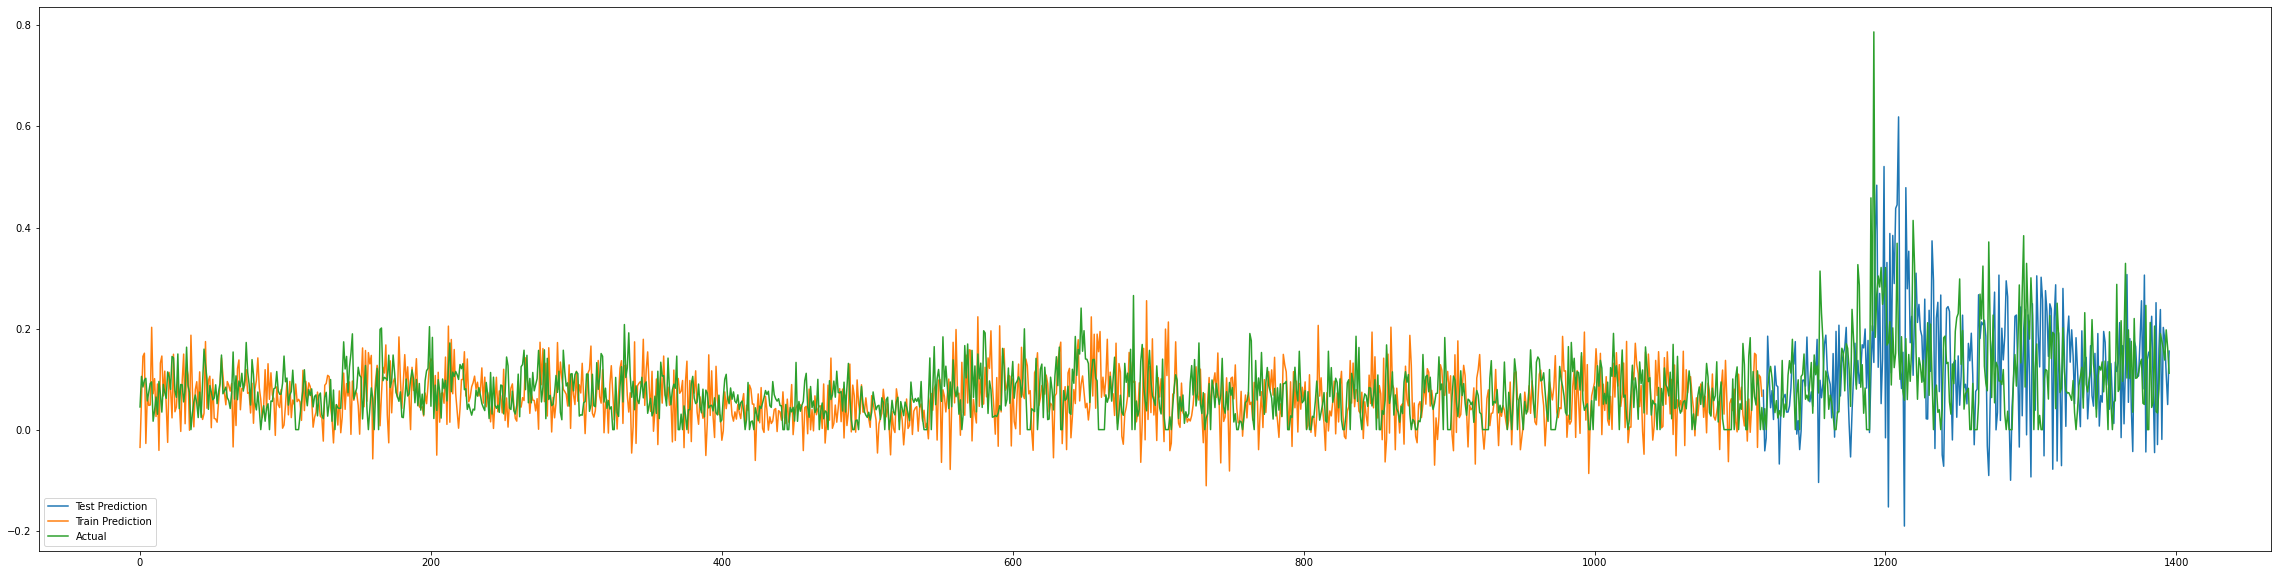

Deviation Min [1.21065542e-05], Max [0.89749238]
Deviation 99.7th pctile [0.50210533]
Deviation > 99.7th pctile is_anomaly labels in data (array([0, 1]), array([1391,    5]))
Actual is_anomaly labels in data (array([0, 1]), array([1394,    2]))
Confusion matrix 
[[1390    4]
 [   1    1]]
precision 0.20000, recall 0.50000, f1 0.28571
Time to train: 994 ms
File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_10.csv
Column Name  value Index  1
Target Column Name  is_anomaly Index  2
Shapes: Xtrain (1132, 24), Ytrain (1132, 1), Xtest (283, 24), Ytest (283, 1)
Train Score: 0.03573 MSE 0.18901 RMSE
Test Score: 0.15221 MSE 0.39014 RMSE


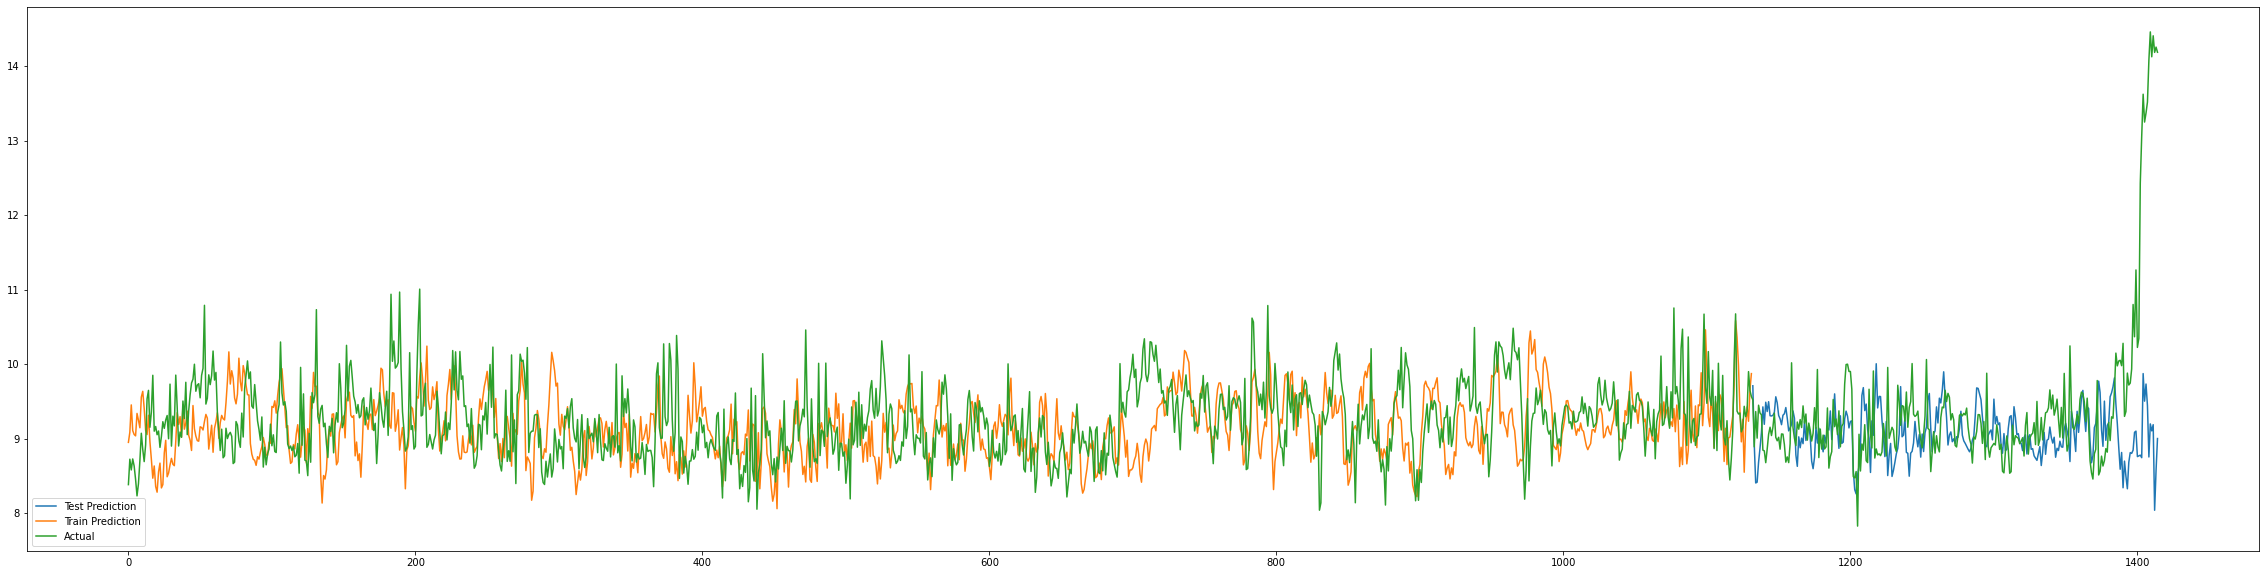

Deviation Min [0.00072131], Max [0.63870349]
Deviation 99.7th pctile [0.58437664]
Deviation > 99.7th pctile is_anomaly labels in data (array([0, 1]), array([1410,    5]))
Actual is_anomaly labels in data (array([0, 1]), array([1402,   13]))
Confusion matrix 
[[1398    4]
 [  12    1]]
precision 0.20000, recall 0.07692, f1 0.11111
Time to train: 948 ms
---------------------START PRINTING SUMMARY FOR A1Benchmark ---------------------
Avg precision 0.20000 recall 0.28846 f1 0.19841 time to train 971.00 ms
---------------------DONE PRINTING SUMMARY FOR A1Benchmark ---------------------
File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_1.csv
Column Name  value Index  1
Target Column Name  is_anomaly Index  2
Shapes: Xtrain (1117, 24), Ytrain (1117, 1), Xtest (280, 24), Ytest (280, 1)
Train Score: 0.01315 MSE 0.11469 RMSE
Test Score: 0.00875 MSE 0.09357 RMSE


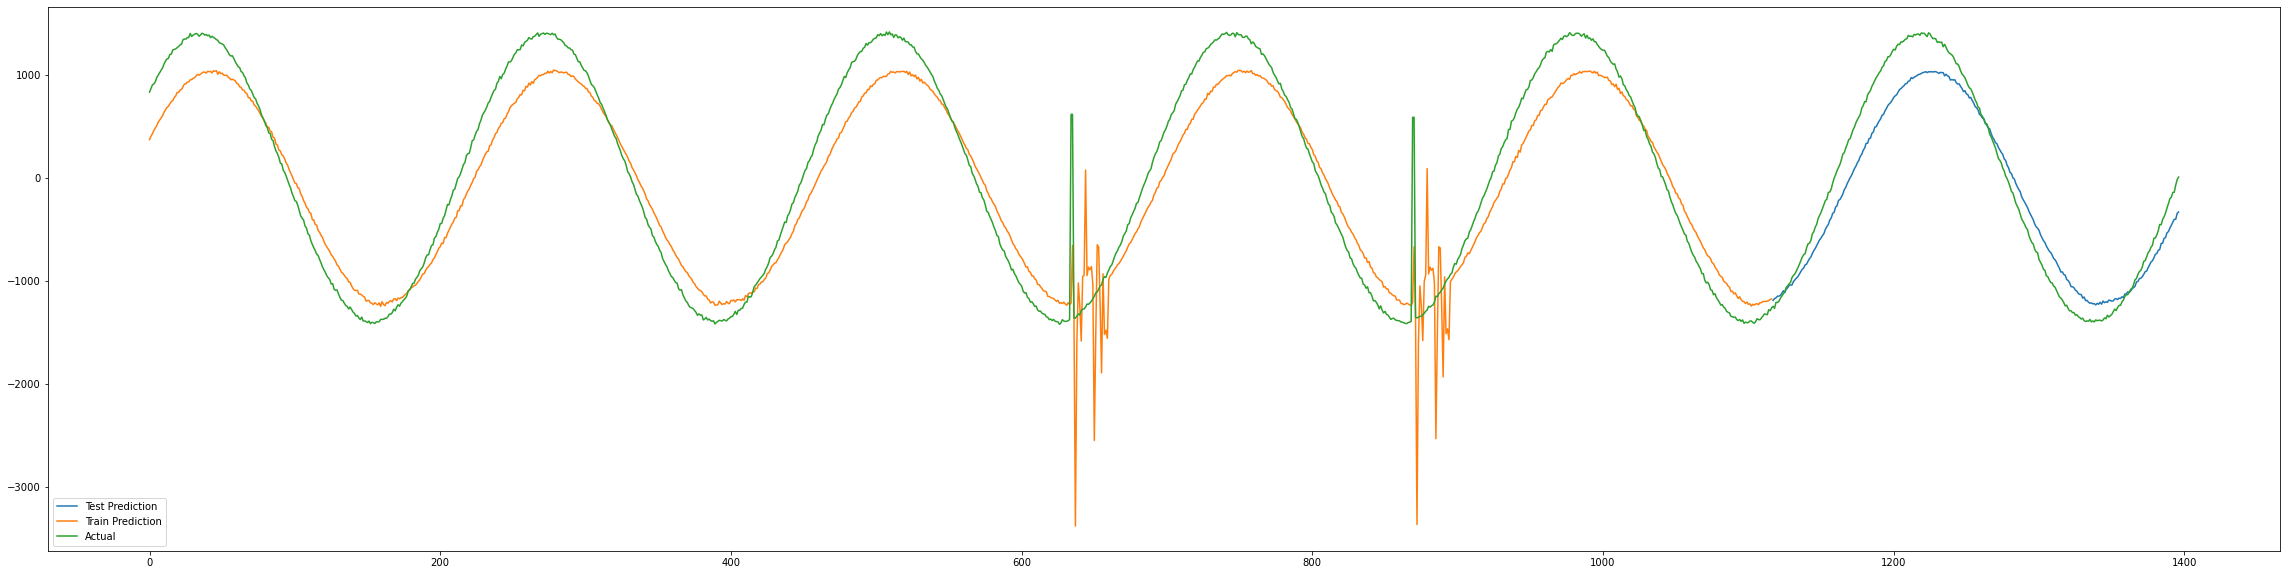

Deviation Min [0.00044185], Max [0.71115751]
Deviation 99.7th pctile [0.49194899]
Deviation > 99.7th pctile is_anomaly labels in data (array([0, 1]), array([1392,    5]))
Actual is_anomaly labels in data (array([0, 1]), array([1393,    4]))
Confusion matrix 
[[1390    3]
 [   2    2]]
precision 0.40000, recall 0.50000, f1 0.44444
Time to train: 599 ms
File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_10.csv
Column Name  value Index  1
Target Column Name  is_anomaly Index  2
Shapes: Xtrain (1117, 24), Ytrain (1117, 1), Xtest (280, 24), Ytest (280, 1)
Train Score: 0.01031 MSE 0.10151 RMSE
Test Score: 0.01057 MSE 0.10280 RMSE


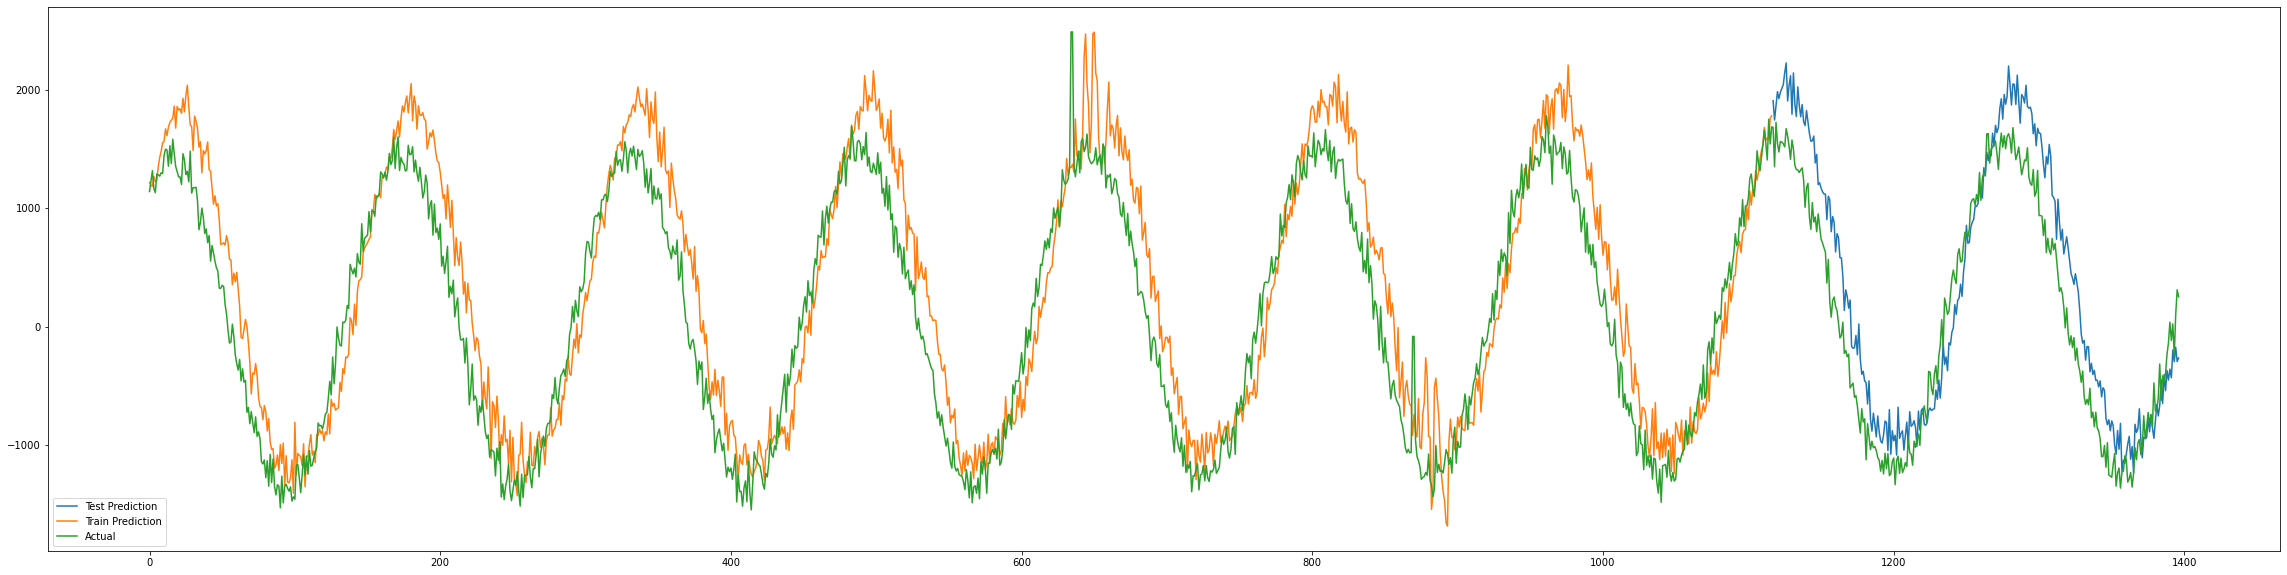

Deviation Min [5.55467332e-05], Max [0.28377759]
Deviation 99.7th pctile [0.23987404]
Deviation > 99.7th pctile is_anomaly labels in data (array([0, 1]), array([1392,    5]))
Actual is_anomaly labels in data (array([0, 1]), array([1393,    4]))
Confusion matrix 
[[1390    3]
 [   2    2]]
precision 0.40000, recall 0.50000, f1 0.44444
Time to train: 1154 ms
---------------------START PRINTING SUMMARY FOR A2Benchmark ---------------------
Avg precision 0.40000 recall 0.50000 f1 0.44444 time to train 876.50 ms
---------------------DONE PRINTING SUMMARY FOR A2Benchmark ---------------------
File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS1.csv
Column Name  value Index  1
Target Column Name  anomaly Index  2
Shapes: Xtrain (1324, 24), Ytrain (1324, 1), Xtest (332, 24), Ytest (332, 1)
Train Score: 0.01382 MSE 0.11755 RMSE
Test Score: 0.01475 MSE 0.12146 RMSE


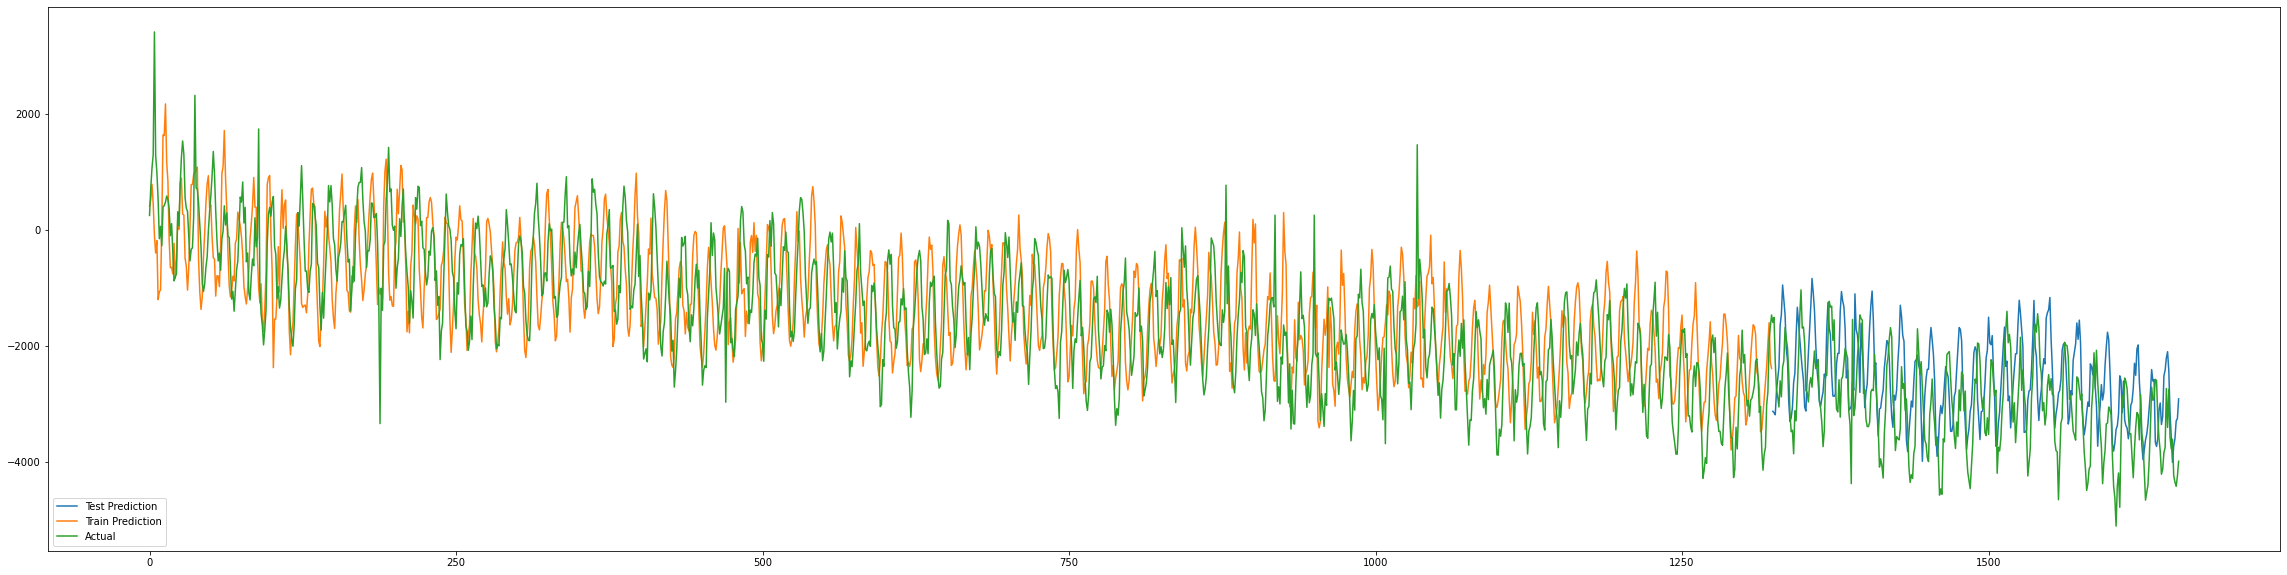

Deviation Min [0.00010917], Max [0.42199737]
Deviation 99.7th pctile [0.30683876]
Deviation > 99.7th pctile is_anomaly labels in data (array([0, 1]), array([1651,    5]))
Actual is_anomaly labels in data (array([0, 1]), array([1645,   11]))
Confusion matrix 
[[1644    1]
 [   7    4]]
precision 0.80000, recall 0.36364, f1 0.50000
Time to train: 912 ms
File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS10.csv
Column Name  value Index  1
Target Column Name  anomaly Index  2
Shapes: Xtrain (1324, 24), Ytrain (1324, 1), Xtest (332, 24), Ytest (332, 1)
Train Score: 0.00219 MSE 0.04684 RMSE
Test Score: 0.00369 MSE 0.06075 RMSE


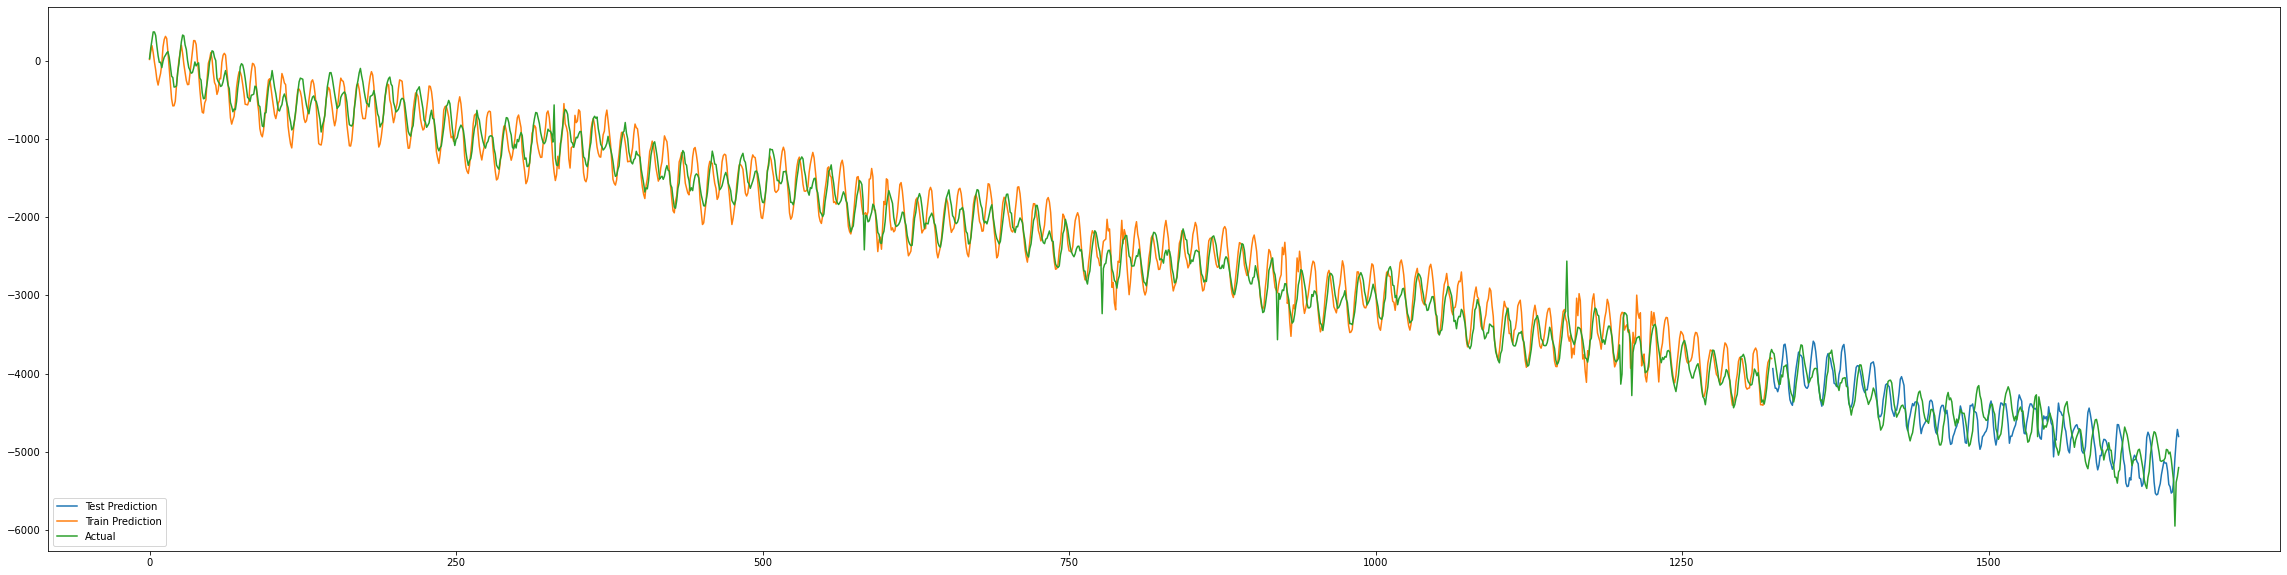

Deviation Min [2.14790228e-05], Max [0.15755442]
Deviation 99.7th pctile [0.09990606]
Deviation > 99.7th pctile is_anomaly labels in data (array([0, 1]), array([1651,    5]))
Actual is_anomaly labels in data (array([0, 1]), array([1646,   10]))
Confusion matrix 
[[1645    1]
 [   6    4]]
precision 0.80000, recall 0.40000, f1 0.53333
Time to train: 897 ms
---------------------START PRINTING SUMMARY FOR A3Benchmark ---------------------
Avg precision 0.80000 recall 0.38182 f1 0.51667 time to train 904.50 ms
---------------------DONE PRINTING SUMMARY FOR A3Benchmark ---------------------
File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS1.csv
Column Name  value Index  1
Target Column Name  anomaly Index  2
Shapes: Xtrain (1324, 24), Ytrain (1324, 1), Xtest (332, 24), Ytest (332, 1)
Train Score: 0.00619 MSE 0.07867 RMSE
Test Score: 0.00768 MSE 0.08761 RMSE


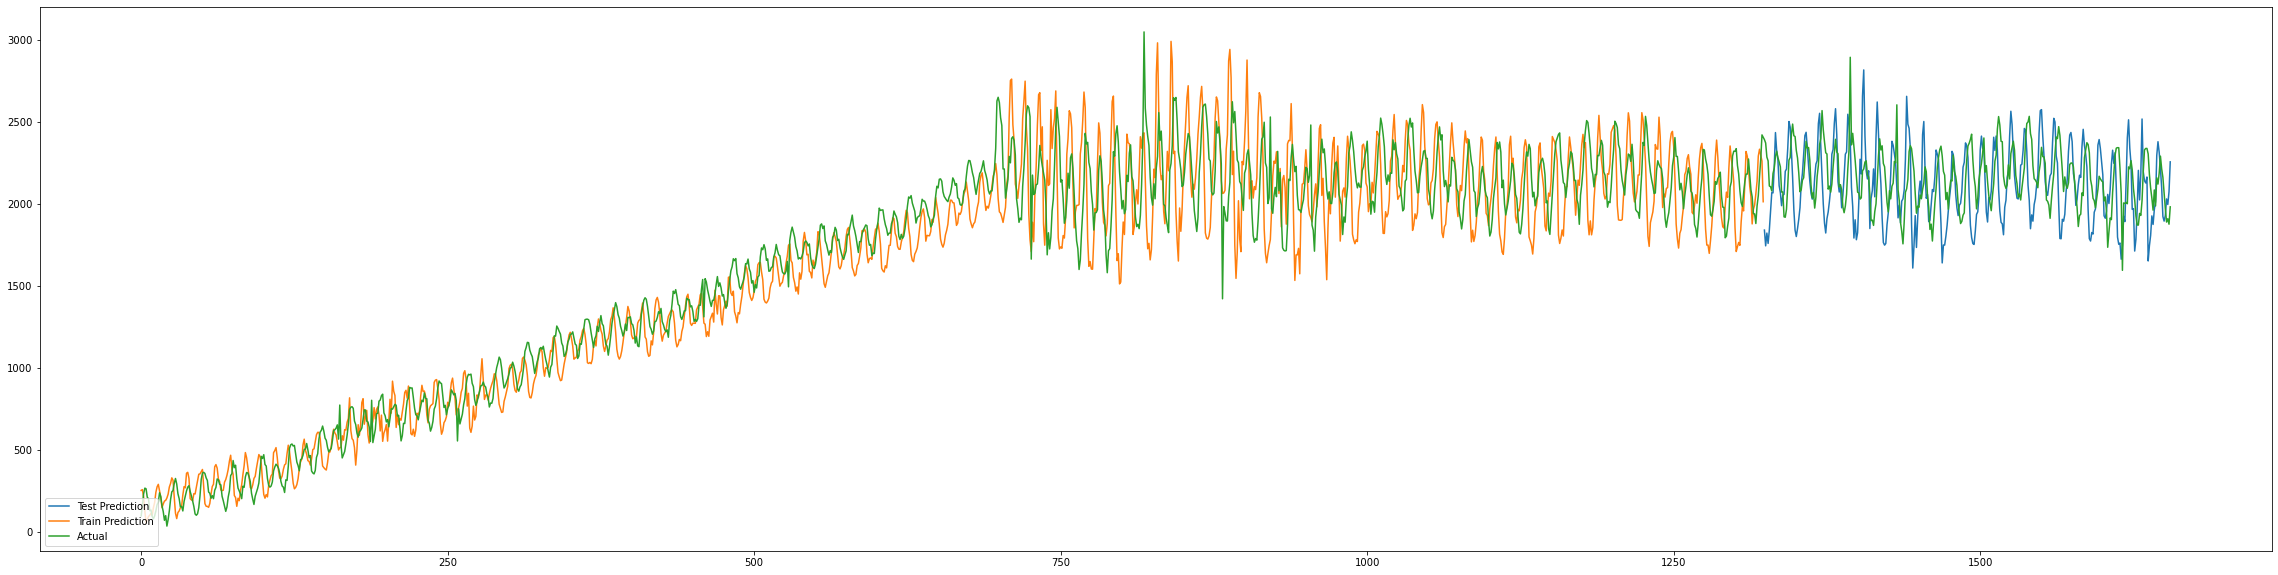

Deviation Min [1.45261126e-05], Max [0.29109826]
Deviation 99.7th pctile [0.26101671]
Deviation > 99.7th pctile is_anomaly labels in data (array([0, 1]), array([1651,    5]))
Actual is_anomaly labels in data (array([0, 1]), array([1643,   13]))
Confusion matrix 
[[1638    5]
 [  13    0]]
precision 0.00000, recall 0.00000, f1 0.00000
Time to train: 1152 ms
File Name :  ../../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS10.csv
Column Name  value Index  1
Target Column Name  anomaly Index  2
Shapes: Xtrain (1324, 24), Ytrain (1324, 1), Xtest (332, 24), Ytest (332, 1)
Train Score: 0.04246 MSE 0.20606 RMSE
Test Score: 0.05441 MSE 0.23327 RMSE


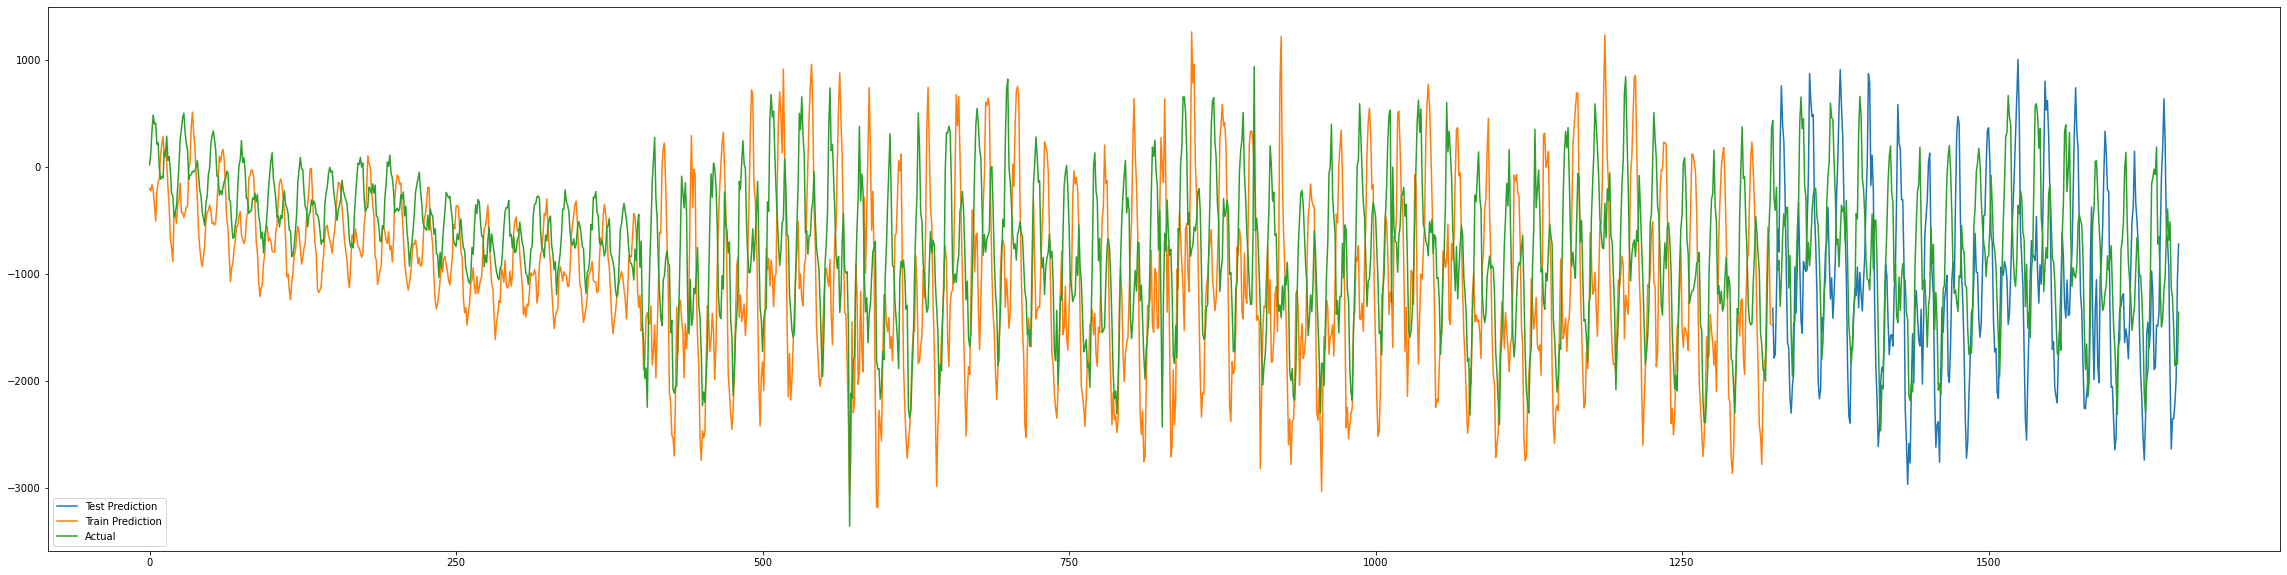

Deviation Min [0.000239], Max [0.6117317]
Deviation 99.7th pctile [0.5320326]
Deviation > 99.7th pctile is_anomaly labels in data (array([0, 1]), array([1651,    5]))
Actual is_anomaly labels in data (array([0, 1]), array([1652,    4]))
Confusion matrix 
[[1648    4]
 [   3    1]]
precision 0.20000, recall 0.25000, f1 0.22222
Time to train: 824 ms
---------------------START PRINTING SUMMARY FOR A4Benchmark ---------------------
Avg precision 0.10000 recall 0.12500 f1 0.11111 time to train 988.00 ms
---------------------DONE PRINTING SUMMARY FOR A4Benchmark ---------------------


In [20]:
num_files_to_process_per_directory = 2
for directory in DIRS:
    benchmark_dir = YAHOO_DS + os.path.sep + directory + os.path.sep 
    timeVariantColumns = ['value']
    if directory == 'A1Benchmark' or directory == 'A2Benchmark' :
        targetColumns = ['is_anomaly'] 
    else :
        targetColumns = ['anomaly'] 
    metricsMap = perform_training_on_benchmark_directories (benchmark_dir, timeVariantColumns, targetColumns, num_files_to_process_per_directory)
    print_summary_for_benchmark_folder(metricsMap, directory)